In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

In [8]:
# Load your dataset in XLSX format
data = pd.read_excel('final version of data.xlsx')

# Assuming your dataset has a 'date' column and a 'consumption' column
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data = data.drop(['no'], axis=1)
data = data.replace({'day':{'Saturday':1, 'Sunday':2, 'Monday':3, 'Tuesday':4, 'Wednesday':5, 'Thursday':6, 'Friday':7}})
print(data.head())
print(len(data))

            time (hour)  year  cons (m3/unit)  month  day  holiday  T air©
date                                                                      
2023-02-03           12  2023        0.525037      3    6        0    18.2
2023-02-03           13  2023        0.487244      3    6        0    18.0
2023-02-03           14  2023        0.472253      3    6        0    17.0
2023-02-03           15  2023        0.469390      3    6        0    15.8
2023-02-03           16  2023        0.481152      3    6        0    12.0
6429


In [9]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [10]:
train_data = train_data.dropna()

In [11]:
y_train = train_data['cons (m3/unit)'].to_numpy()
X_train = train_data.drop(['cons (m3/unit)'], axis=1).to_numpy()
y_test = test_data['cons (m3/unit)'].to_numpy()
X_test = test_data.drop(['cons (m3/unit)'], axis=1).to_numpy()

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(X_train)
def create_proper_dataset_for_rnn(inputs, labels, look_back):
  new_inputs = []
  new_labels = []
  for i in range(len(inputs) - look_back):
    x = inputs[i:i+look_back, :]
    y = labels[look_back]
    new_inputs.append(x)
    new_labels.append(y)
  return np.array(new_inputs), np.array(new_labels)
look_back = 12
prepared_X_train, prepared_Y_train = create_proper_dataset_for_rnn(X_train, y_train, look_back)
prepared_X_test, prepared_Y_test = create_proper_dataset_for_rnn(X_test, y_test, look_back)
X_train.shape

(5142, 6)

In [13]:
# Create and compile the LSTM model
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 6)))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
# The output layer
model.add(Flatten())
model.add(Dense(units=1, activation='linear'))
# Compiling the RNN
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 6, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 6, 50)             20200     
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 51101 (199.61 KB)
Trainable params: 51101 (199.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=60,batch_size=64)

Epoch 1/60
81/81 [==============================] - 11s 8ms/step - loss: 0.0171
Epoch 2/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 3/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 4/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 5/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 6/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0031
Epoch 7/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 8/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 9/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 10/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 11/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 12/60
81/81 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 13/60
81/81 [=============================

In [15]:
predicted = model.predict(X_test)

41/41 [==============================] - 1s 4ms/step


In [16]:
predicted.shape

(1286, 1)

In [17]:
r2 = r2_score(y_test, predicted)
print('r2 score for perfect model is', r2)

r2 score for perfect model is -4.2851950921001585


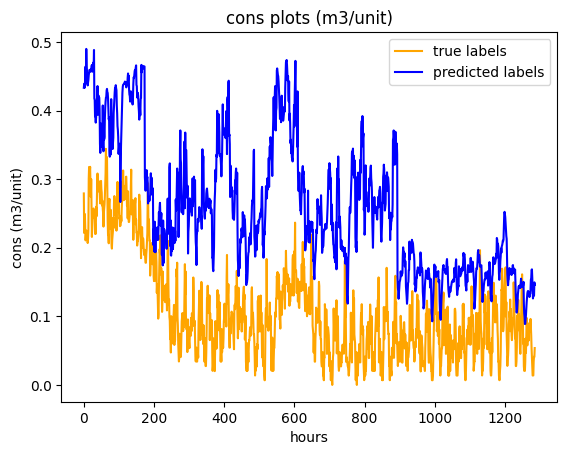

In [18]:
plt.plot(np.arange(len(y_test)),y_test, color='orange', label='true labels')
plt.plot(np.arange(len(y_test)),predicted, color='blue', label='predicted labels')
plt.title('cons plots (m3/unit)')
plt.xlabel('hours')
plt.ylabel('cons (m3/unit)')
plt.legend()